In [10]:
import sys, os
import importlib
import src.utils.data_loader as dl

# Force reload the module so changes are picked up
importlib.reload(dl)

from dotenv import load_dotenv
load_dotenv()


# Add project root to Python path
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

from src.utils.data_loader import load_reviews, load_weather

# Load data
reviews = load_reviews()
weather = load_weather()

print("Reviews sample:\n", reviews.head(), "\n")
print("Weather sample:\n", weather.head())


Reviews sample:
    review_id  customer_id                                 review_text  rating  \
0          1          101  Package arrived late but in good condition       3   
1          2          102  The box was damaged and items were missing       1   
2          3          103                  Fast delivery, very happy!       5   
3          4          104            Delivery was delayed due to rain       2   
4          5          105   Package arrived on time and neatly packed       4   

         date  
0  2023-09-01  
1  2023-09-02  
2  2023-09-03  
3  2023-09-04  
4  2023-09-05   

Weather sample:
          date location  temperature_c   condition
0  2023-09-01    Delhi             34       Sunny
1  2023-09-02    Delhi             32        Rain
2  2023-09-03    Delhi             35       Sunny
3  2023-09-04    Delhi             28  Heavy Rain
4  2023-09-05    Delhi             33      Cloudy


In [9]:
import inspect
import src.utils.data_loader as dl   # import the whole module

# List all attributes (functions, classes, variables) inside data_loader.py
print("Available in data_loader:", dir(dl))

# Show the actual source code Python is using
print("\n=== File content being imported ===\n")
print(inspect.getsource(dl))


Available in data_loader: ['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__']

=== File content being imported ===

import pandas as pd
import os

# Build paths relative to project root
BASE_DIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
DATA_DIR = os.path.join(BASE_DIR, "data")

def load_reviews(filename="reviews.csv"):
    """Load reviews dataset"""
    filepath = os.path.join(DATA_DIR, filename)
    return pd.read_csv(filepath)

def load_weather(filename="weather.csv"):
    """Load weather dataset"""
    filepath = os.path.join(DATA_DIR, filename)
    return pd.read_csv(filepath)



In [11]:
print(reviews.isnull().sum())


review_id      0
customer_id    0
review_text    0
rating         0
date           0
dtype: int64


In [13]:
import pandas as pd

In [14]:
reviews['date'] = pd.to_datetime(reviews['date'])


In [15]:
import re
reviews['clean_text'] = reviews['review_text'].str.lower().str.replace(r'[^\w\s]', '', regex=True)


In [16]:
def sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

reviews['sentiment'] = reviews['rating'].apply(sentiment)


Clean the Weather Dataset

In [17]:
weather['date'] = pd.to_datetime(weather['date'])


In [18]:
weather['condition'] = weather['condition'].replace({'S':'Sunny'})


In [19]:
merged_df = pd.merge(reviews, weather, on='date', how='left')


In [20]:
print(merged_df.head())


   review_id  customer_id                                 review_text  rating  \
0          1          101  Package arrived late but in good condition       3   
1          2          102  The box was damaged and items were missing       1   
2          3          103                  Fast delivery, very happy!       5   
3          4          104            Delivery was delayed due to rain       2   
4          5          105   Package arrived on time and neatly packed       4   

        date                                  clean_text sentiment location  \
0 2023-09-01  package arrived late but in good condition   neutral    Delhi   
1 2023-09-02  the box was damaged and items were missing  negative    Delhi   
2 2023-09-03                    fast delivery very happy  positive    Delhi   
3 2023-09-04            delivery was delayed due to rain  negative    Delhi   
4 2023-09-05   package arrived on time and neatly packed  positive    Delhi   

   temperature_c   condition  
0      

EDA

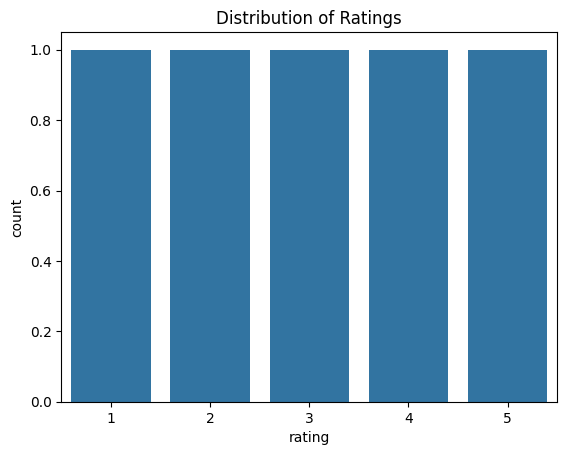

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=merged_df, x='rating')
plt.title("Distribution of Ratings")
plt.show()


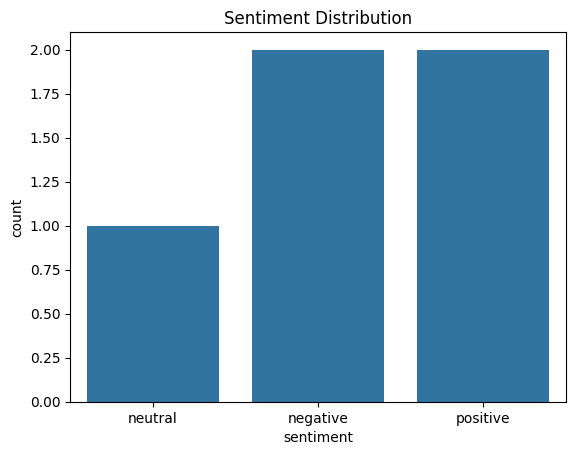

In [23]:
sns.countplot(data=merged_df, x='sentiment')
plt.title("Sentiment Distribution")
plt.show()


In [24]:
#Text analysis of reviews
from collections import Counter

neg_words = ' '.join(merged_df[merged_df['sentiment']=='negative']['clean_text']).split()
Counter(neg_words).most_common(10)


[('was', 2),
 ('the', 1),
 ('box', 1),
 ('damaged', 1),
 ('and', 1),
 ('items', 1),
 ('were', 1),
 ('missing', 1),
 ('delivery', 1),
 ('delayed', 1)]

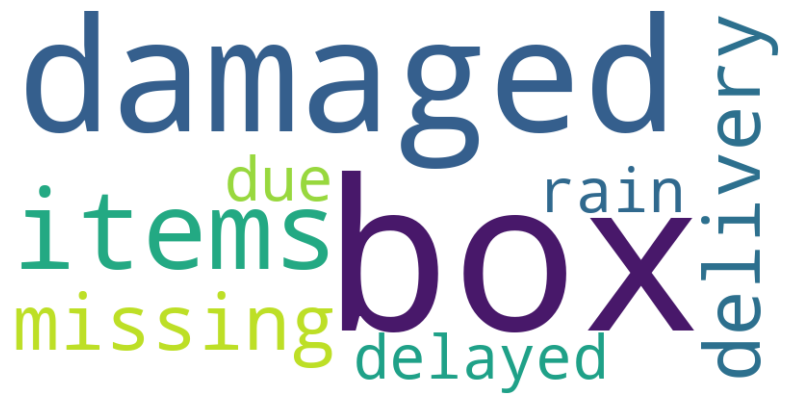

In [26]:
#word count for negative reviews
from wordcloud import WordCloud

text = ' '.join(merged_df[merged_df['sentiment']=='negative']['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


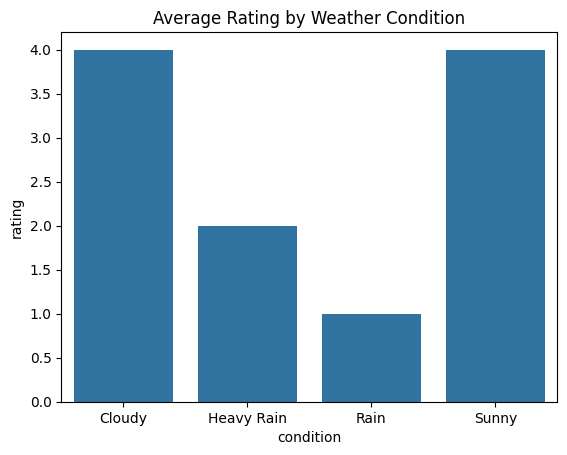

In [27]:
#Weather vs.Delivery Ratings
avg_rating_weather = merged_df.groupby('condition')['rating'].mean().reset_index()
sns.barplot(data=avg_rating_weather, x='condition', y='rating')
plt.title("Average Rating by Weather Condition")
plt.show()


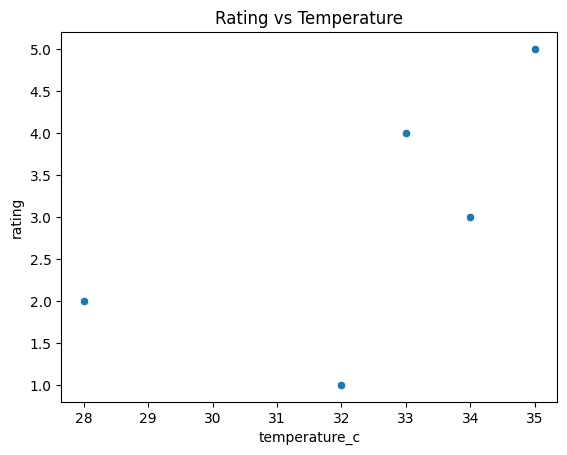

In [28]:
#Temperature vs. Ratings
sns.scatterplot(data=merged_df, x='temperature_c', y='rating')
plt.title("Rating vs Temperature")
plt.show()


Topic Modelling/NLP Insights

In [29]:
###Procissing Text for Topic Modelling
# Already done basic cleaning: lowercase, remove punctuation, stopwords
# Optionally, remove very common words like "package", "delivery" if too frequent
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

merged_df['clean_text2'] = merged_df['clean_text'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop_words])
)


In [32]:
from bertopic import BERTopic
from umap import UMAP

# Configure UMAP for very small dataset
umap_model = UMAP(n_neighbors=2, n_components=2, metric='cosine', random_state=42)

# Create BERTopic model
topic_model = BERTopic(umap_model=umap_model, language="english")

topics, probs = topic_model.fit_transform(merged_df['clean_text2'])


ValueError: k must be less than or equal to the number of training points

In [31]:
##Topic modelling with BERTopic


from bertopic import BERTopic

# Create the topic model
topic_model = BERTopic(language="english")
topics, probs = topic_model.fit_transform(merged_df['clean_text2'])

# Add topics to dataframe
merged_df['topic'] = topics


c:\Users\91824\delivery-detective\venv\lib\site-packages\umap\spectral.py:519: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.

c:\Users\91824\delivery-detective\venv\lib\site-packages\umap\spectral.py:519: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



TypeError: Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.

In [ ]:
#Inspect topics
# See top 10 topics and representative words
topic_model.get_topic_info()

# See keywords for a specific topic
topic_model.get_topic(0)  # Replace 0 with topic number


In [ ]:
#Analyze topics with ratings and weather
# Average rating per topic
merged_df.groupby('topic')['rating'].mean()

# Topic counts per weather condition
merged_df.groupby(['condition', 'topic']).size().unstack(fill_value=0)


In [ ]:
#Visualization
topic_model.visualize_topics()
topic_model.visualize_distribution(probs[0:len(merged_df)])
